In [19]:
import stats
import compare_vcf as comp
from read_vcf import parse_vcf
import re
import numpy as np
import matplotlib.pyplot as plt
from read_ORF import list_interval_with_dico


try: 
    data = [parse_vcf(f'data-p90/P90-{i}.trimed1000.sv_sniffles.fixed.vcf') for i in range(1, 11)]

# Generate fixed files if needed (fix coverage = None sniffle error)
except FileNotFoundError:
    pattern = r'(COVERAGE=[^;]*)(None)([^;]*;)'
    replacement = r'\g<1>0\g<3>'

    for i in range(1, 11):
        with open(f'data-p90/P90-{i}.trimed1000.sv_sniffles.vcf', 'r') as infile:
            file_contents = infile.read()

        modified_contents = re.sub(pattern, replacement, file_contents)

        with open(f'data-p90/P90-{i}.trimed1000.sv_sniffles.fixed.vcf', 'w') as outfile:
            outfile.write(modified_contents)
    
    data = [parse_vcf(f'data-p90/P90-{i}.trimed1000.sv_sniffles.fixed.vcf') for i in range(1, 11)]

all_variant = sum(data, [])
heat_group = sum([data[i] for i in range(0, 4)], [])
cold_group = sum([data[i] for i in range(4, 10)], [])

### Distribution of Frequency and Depth

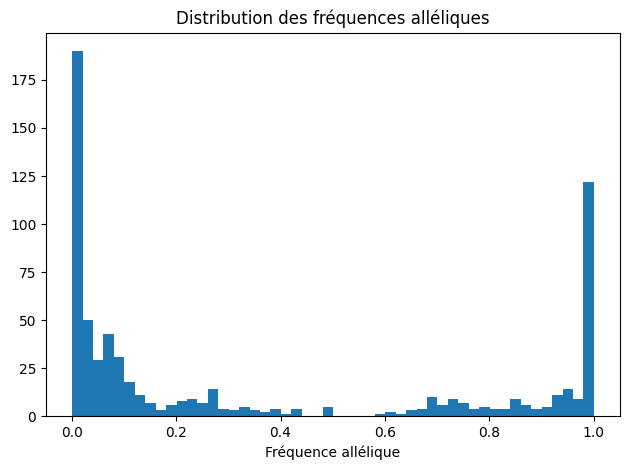

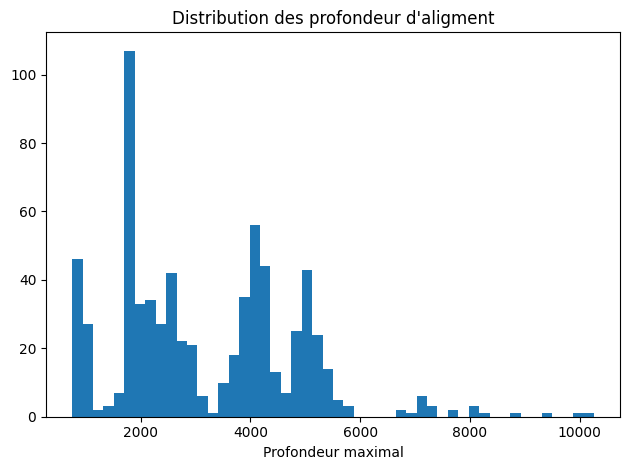

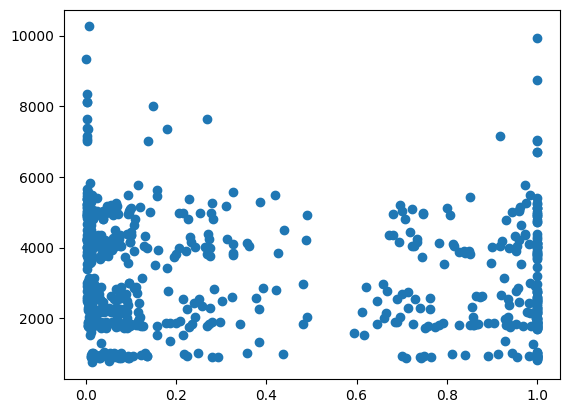

In [20]:
af = [v["af"] for v in all_variant]
depth = [max(v["depth"]) for v in all_variant]

fig, ax = plt.subplots()
ax.hist(af, bins=50)
ax.set_xlabel('Fréquence allélique')
ax.set_title("Distribution des fréquences alléliques")
fig.tight_layout()
plt.show()

fig, ax = plt.subplots()
ax.hist(depth, bins=50)
ax.set_xlabel('Profondeur maximal')
ax.set_title("Distribution des profondeur d'aligment")
fig.tight_layout()
plt.show()

#fig, ax = plt.subplots()
#h = ax.hist2d(af, depth, bins=(30, 30))
#fig.colorbar(h[3], ax=ax)
#ax.set_xlabel('Fréquence allélique')
#ax.set_ylabel('Valeur de profondeur maximal')
#ax.set_title("Distribution des fréquences par profondeur")
#fig.tight_layout()
#plt.show()

# Fixing random state for reproducibility
np.random.seed(19680801)

x = np.random.rand(20)
y = 1e7 * np.random.rand(20)

fig, ax = plt.subplots()
plt.plot(af, depth, 'o')
plt.show()

### Filter variants based on Frequency and Depth

In [21]:
min_depth = 500
min_freq = 0.2
data = [[v for v in d if v['af'] > min_freq and max(v['depth'])> min_depth] for d in data]

### Plot basic statistics on variants

#### Merge avancé : une variation présente à l'identique dans deux échantillons n'est compté qu'une fois

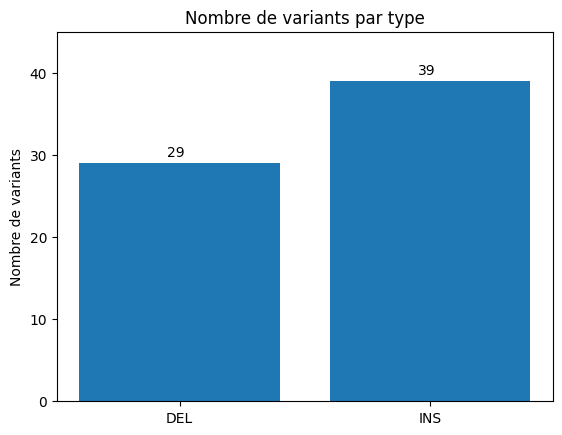

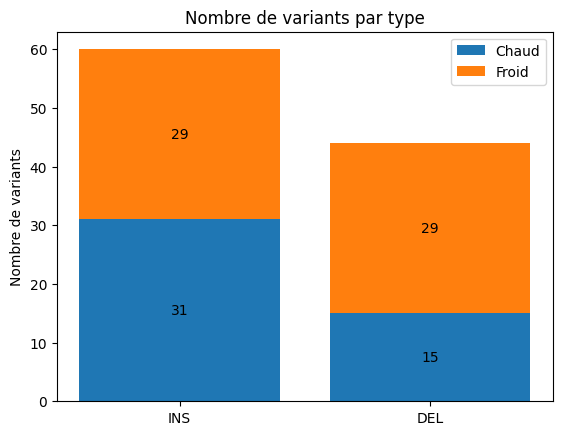

In [22]:
thresold = 1
all_variant_grouped = comp.merge_samples(data, sim_thresold=thresold)
heat_group_grouped = comp.merge_samples(data[0:5], sim_thresold=thresold)
cold_group_grouped = comp.merge_samples(data[5:10], sim_thresold=thresold)

counts_all = stats.count_types([grp[0][1]["svtype"] for grp in all_variant_grouped])
counts_heat = stats.count_types([grp[0][1]["svtype"] for grp in heat_group_grouped])
counts_cold = stats.count_types([grp[0][1]["svtype"] for grp in cold_group_grouped])

grouped_labels = list( set(counts_heat.keys()).union(counts_heat.keys()) )
grouped_counts = {
    "Chaud": [counts_heat[k] if k in counts_heat else 0 for k in grouped_labels],
    "Froid": [counts_cold[k] if k in counts_cold else 0 for k in grouped_labels]
}

stats.plot_count_by_type(counts_all)
stats.plot_grouped_count_by_type(grouped_counts, grouped_labels)

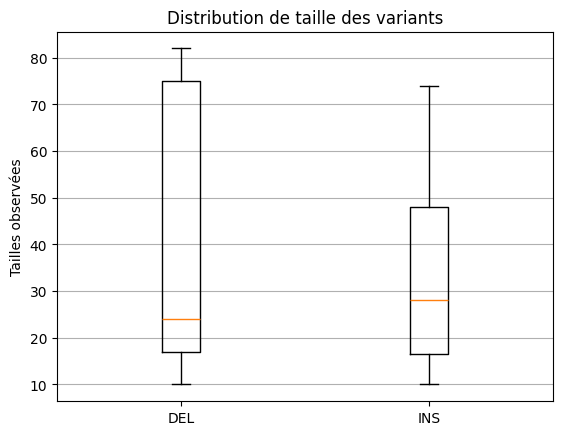

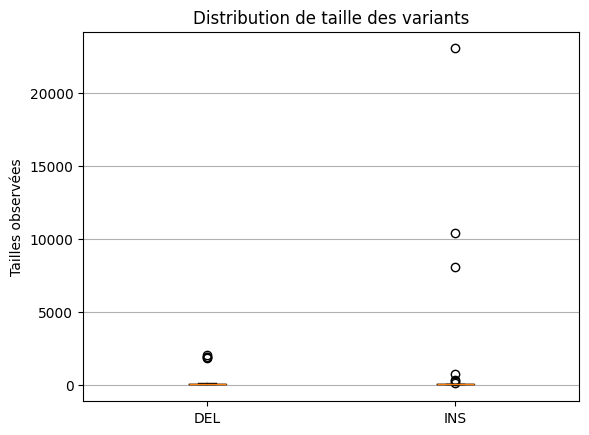

In [23]:
len_distrib_all = stats.len_by_type([(grp[0][1]["svtype"], np.mean([x[1]["svlen"] for x in grp])) for grp in all_variant_grouped])
stats.plot_len_by_type(len_distrib_all, False)
stats.plot_len_by_type(len_distrib_all, True)


### Plot similarity heatmap between samples

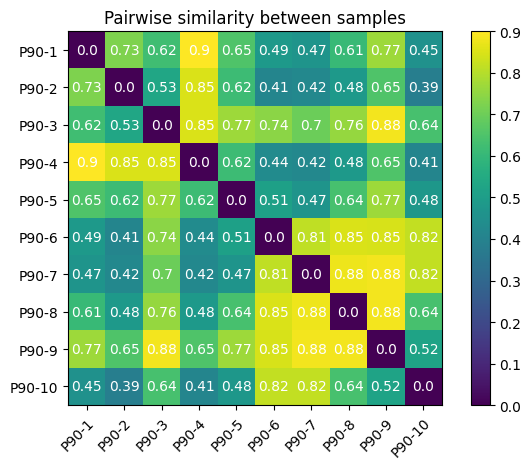

In [24]:
sims = comp.pairwise_similarity(list(range(0, 10)), all_variant_grouped)
comp.variant_heatmap(sims, [f"P90-{i}" for i in range(1, 11)])

### Extraire les variants présent uniquement dans le chaud ou le froid

In [25]:
only_heat = []
only_cold = []
for g in all_variant_grouped:
    present_in = 0
    for v in g:
        if v[0] <= 4:
            present_in = present_in | 1
        elif v[0] <= 9:
            present_in = present_in | 2
        else:
            print("tu t'es foiré")
    if present_in == 0:
        print("tu t'es foiré")
    elif present_in == 1:
        only_heat.append(g[0][1])
    elif present_in == 2:
        only_cold.append(g[0][1])


#### Seulement dans le chaud

In [26]:
for h in only_heat:
    print(h)


{'pos': 37879, 'id': 'Sniffles2.INS.70S0', 'svtype': 'INS', 'svlen': 26, 'end': 37879, 'af': 0.671, 'depth': [4318.0, 4144.0, 4172.0, 4157.0, 4353.0], 'alt': [TGTGTGTGTGTGTGTGTGTGTGTGTG]}
{'pos': 37879, 'id': 'Sniffles2.INS.3BS0', 'svtype': 'INS', 'svlen': 28, 'end': 37879, 'af': 0.681, 'depth': [4881.0, 4668.0, 4683.0, 4688.0, 4959.0], 'alt': [TGTGTGTGTGTGTGTGTGTGTGTGTG]}
{'pos': 83046, 'id': 'Sniffles2.INS.FFS0', 'svtype': 'INS', 'svlen': 39, 'end': 83046, 'af': 0.234, 'depth': [4148.0, 4147.0, 4124.0, 4094.0, 4109.0], 'alt': [ACCAGAAGCAGCCGAAGCAGCCGAAGCAGCCGAAGC]}
{'pos': 83076, 'id': 'Sniffles2.INS.EDS0', 'svtype': 'INS', 'svlen': 48, 'end': 83076, 'af': 0.746, 'depth': [3694.0, 3725.0, 3687.0, 3639.0, 3637.0], 'alt': [CGAAGCAGCCGAAGCAGCCGAAGCAGCCGAAGCAGACCAAACCCGACG]}
{'pos': 270829, 'id': 'Sniffles2.INS.33BS0', 'svtype': 'INS', 'svlen': 19, 'end': 270829, 'af': 0.8, 'depth': [4962.0, 4868.0, 5040.0, 5113.0, 5105.0], 'alt': [ACAGAGACACAAAACAGAC]}
{'pos': 272444, 'id': 'Sniffles2.I

#### Seulement dans le froid

A noter : grosses insertions au bout du génome : a cause du troncage ??

In [27]:
for c in only_cold:
    print(c)

{'pos': 9457, 'id': 'Sniffles2.DEL.1D5S0', 'svtype': 'DEL', 'svlen': -17, 'end': 9474, 'af': 0.594, 'depth': [1572.0, 1551.0, 1499.0, 1489.0, 1399.0]}
{'pos': 11384, 'id': 'Sniffles2.DEL.26BS0', 'svtype': 'DEL', 'svlen': -33, 'end': 11417, 'af': 1.0, 'depth': [3304.0, 3337.0, 3329.0, 3400.0, 3455.0]}
{'pos': 15501, 'id': 'Sniffles2.INS.35S0', 'svtype': 'INS', 'svlen': 12, 'end': 15501, 'af': 1.0, 'depth': [6742.0, 6831.0, 6910.0, 6939.0, 7022.0], 'alt': [TCATCATCATCA]}
{'pos': 16096, 'id': 'Sniffles2.DEL.1E5S0', 'svtype': 'DEL', 'svlen': -12, 'end': 16108, 'af': 0.616, 'depth': [1356.0, 1431.0, 1473.0, 1482.0, 1536.0]}
{'pos': 16098, 'id': 'Sniffles2.DEL.1E6S0', 'svtype': 'DEL', 'svlen': -20, 'end': 16118, 'af': 0.216, 'depth': [1356.0, 1431.0, 1473.0, 1482.0, 1536.0]}
{'pos': 21083, 'id': 'Sniffles2.DEL.1F3S0', 'svtype': 'DEL', 'svlen': -10, 'end': 21093, 'af': 0.383, 'depth': [1324.0, 1172.0, 1174.0, 1166.0, 1178.0]}
{'pos': 32540, 'id': 'Sniffles2.DEL.27FS0', 'svtype': 'DEL', 'svlen

### Garder ceux qui sont dans des ORFs

In [47]:
orfs = list_interval_with_dico()

print("Chauds dans les ORFs : ")
for h in only_heat:
    for orf in orfs:
        found = False
        for inter in orf["location"]:
            fond = found or (min(h["end"], int(inter[1])) - max(h["pos"], int(inter[0])) > 0)
        if found:
            print(" ORF : ", orf)
            print(" Mutation : ", h)
            print()

print("Froids dans les ORFs : ")
for c in only_cold:
    for orf in orfs:
        found = False
        for inter in orf["location"]:
            found = found or (min(c["end"], int(inter[1])) - max(c["pos"], int(inter[0])) > 0)
        if found:
            print(" ORF : ", orf)
            print(" Mutation : ", c)
            print()


Chauds dans les ORFs : 
Froids dans les ORFs : 
 ORF :  {'locus_tag': 'CyHV3_ORF1_1', 'protein_id': 'YP_001096040.1', 'location': [['426', '1199']], 'direct': True, 'complement': False, 'join': False}
 Mutation :  {'pos': 9457, 'id': 'Sniffles2.DEL.1D5S0', 'svtype': 'DEL', 'svlen': -17, 'end': 9474, 'af': 0.594, 'depth': [1572.0, 1551.0, 1499.0, 1489.0, 1399.0]}

 ORF :  {'locus_tag': 'CyHV3_ORF2_1', 'protein_id': 'YP_001096041.1', 'location': [['1635', '3503']], 'direct': False, 'complement': True, 'join': False}
 Mutation :  {'pos': 9457, 'id': 'Sniffles2.DEL.1D5S0', 'svtype': 'DEL', 'svlen': -17, 'end': 9474, 'af': 0.594, 'depth': [1572.0, 1551.0, 1499.0, 1489.0, 1399.0]}

 ORF :  {'locus_tag': 'CyHV3_ORF3_1', 'protein_id': 'YP_001096042.1', 'location': [['4299', '6914']], 'direct': True, 'complement': False, 'join': False}
 Mutation :  {'pos': 9457, 'id': 'Sniffles2.DEL.1D5S0', 'svtype': 'DEL', 'svlen': -17, 'end': 9474, 'af': 0.594, 'depth': [1572.0, 1551.0, 1499.0, 1489.0, 1399.0

## Comparaison entre les itération d'un même échantillon

In [43]:
iterations = ["15", "30", "50", "65", "90"]
sample = 1

try: 
    data2 = [parse_vcf(f'data-p{i}/P{i}-{sample}.trimed1000.sv_sniffles.fixed.vcf') for i in iterations]

# Generate fixed files if needed (fix coverage = None sniffle error)
except FileNotFoundError:
    pattern = r'(None)([;,])'
    replacement = r'0\g<2>'

    for i in iterations:
        with open(f'data-p{i}/P{i}-{sample}.trimed1000.sv_sniffles.vcf', 'r') as infile:
            file_contents = infile.read()

        modified_contents = re.sub(pattern, replacement, file_contents)

        with open(f'data-p{i}/P{i}-{sample}.trimed1000.sv_sniffles.fixed.vcf', 'w') as outfile:
            outfile.write(modified_contents)
    
    data2 = [parse_vcf(f'data-p{i}/P{i}-{sample}.trimed1000.sv_sniffles.fixed.vcf') for i in iterations]

data2 = [[v for v in d if v['af'] > 0. and min_depth > 250] for d in data2]

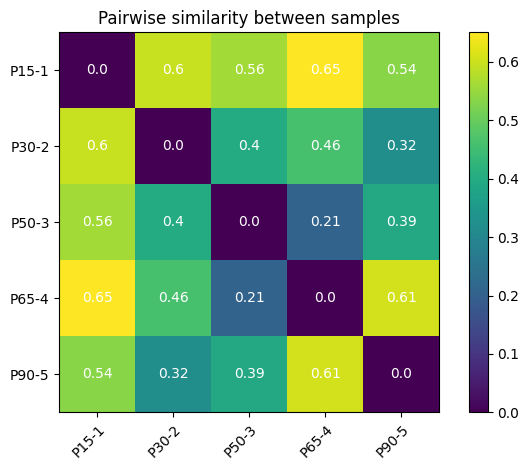

In [44]:
grouped_data2 = comp.merge_samples(data2, sim_thresold=1)
sims2 = comp.pairwise_similarity(list(range(0, 5)), grouped_data2)
comp.variant_heatmap(sims2, [f"P{sample}-{i+1}" for i, sample in enumerate([15, 30, 50, 65, 90])])

### Quantité de variants au fil des itérations

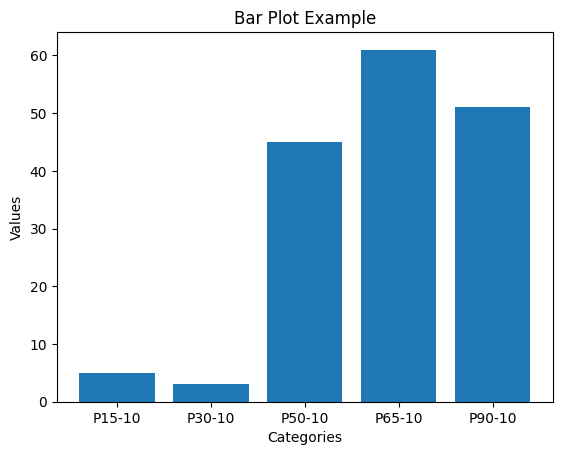

In [41]:
labels = [f"P{it}-{sample}" for it in iterations]
values = [len(d) for d in data2]

# Create a figure and an axis
fig, ax = plt.subplots()

# Create a bar plot on the specified axis
ax.bar(labels, values)

# Adding title and labels
ax.set_title('Bar Plot Example')
ax.set_xlabel('Categories')
ax.set_ylabel('Values')

# Show the plot
plt.show()
